In [1]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
marketing_df = pd.read_csv('../2. data_after_txt_proc/bank_marketing_data_after_txt_proc.csv')
personal_df = pd.read_csv('../2. data_after_txt_proc/Bank_Personal_Loan_Modelling_after_txt_proc.csv')

# marketing_df

In [4]:
X_m = marketing_df.drop(columns=['deposit']) 
y_m = marketing_df['deposit'] 

In [5]:
feature_names_m = X_m.columns.tolist()

In [6]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42)


In [7]:
def objective_m(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10)
    iterations = trial.suggest_int('iterations', 50, 1500, 25)

    model_m = CatBoostClassifier(
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        iterations=iterations,
        silent=True,
        
        random_state=42,
        task_type='GPU'
    )

    score = cross_val_score(model_m, X_train_m, y_train_m, cv=5, scoring='accuracy').mean()
    return score

In [9]:
%%time
study_m = optuna.create_study(direction='maximize')
study_m.optimize(objective_m, n_trials=50)

[I 2024-12-02 23:39:58,399] A new study created in memory with name: no-name-3859c229-26fc-4b5b-8144-447cca75b0b1
C:\Users\mitay\AppData\Local\Temp\ipykernel_17812\3959859804.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
C:\Users\mitay\AppData\Local\Temp\ipykernel_17812\3959859804.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10)
C:\Users\mitay\AppData\Local\Temp\ipykernel_17812\3959859804.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = 

CPU times: total: 9h 24min 21s
Wall time: 9h 3min 56s


In [10]:
print("Best hyperparameters for marketing_df:", study_m.best_params)


Best hyperparameters for marketing_df: {'learning_rate': 0.015009056968356799, 'depth': 10, 'l2_leaf_reg': 8.655218210118262, 'iterations': 1500}


In [11]:
best_model_m = CatBoostClassifier(
    learning_rate=study_m.best_params['learning_rate'],
    depth=study_m.best_params['depth'],
    l2_leaf_reg=study_m.best_params['l2_leaf_reg'],
    iterations=study_m.best_params['iterations'],
    silent=True,
    random_state=42
)

In [12]:
best_model_m.fit(X_train_m, y_train_m)

In [13]:
test_score_m = best_model_m.score(X_test_m, y_test_m)
print(f"Test accuracy for marketing_df: {test_score_m:.4f}")

Test accuracy for marketing_df: 0.8531


In [14]:
feature_importances_m = best_model_m.get_feature_importance(Pool(X_test_m, label=y_test_m))
feature_indices_m = np.argsort(feature_importances_m)[::-1]

print("Feature importance for marketing_df (CatBoost):")
for idx in feature_indices_m:
    print(f"{feature_names_m[idx]}: {feature_importances_m[idx]:.4f}")

Feature importance for marketing_df (CatBoost):
duration: 22.6308
month: 15.6554
day: 10.7756
balance: 6.7358
age: 6.2997
contact_unknown: 5.8395
campaign: 5.1665
housing: 4.6201
poutcome_success: 3.1000
pdays: 2.8867
education_tertiary: 1.7883
contact_cellular: 1.6800
marital_married: 1.3792
previous: 1.3695
education_secondary: 1.1752
marital_single: 1.0662
poutcome_unknown: 0.9155
loan: 0.8976
job_technician: 0.7415
job_management: 0.7129
education_primary: 0.6729
job_admin.: 0.6594
job_blue-collar: 0.6098
poutcome_failure: 0.4160
marital_divorced: 0.4086
job_services: 0.3961
education_unknown: 0.2577
contact_telephone: 0.2558
poutcome_other: 0.1640
job_self-employed: 0.1455
job_retired: 0.1354
job_student: 0.1351
job_entrepreneur: 0.1010
default: 0.0795
job_unemployed: 0.0570
job_housemaid: 0.0494
job_unknown: 0.0210


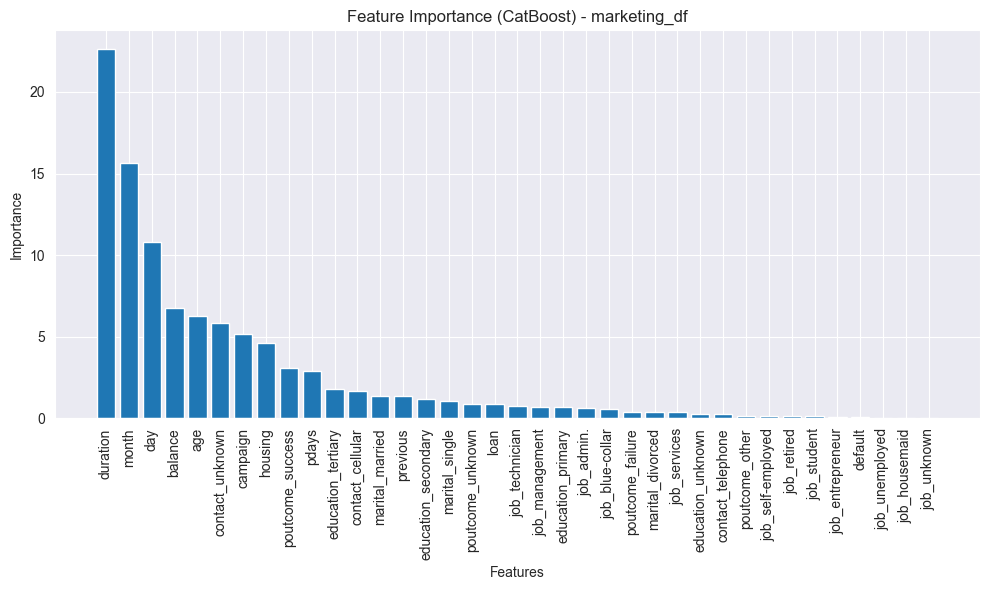

In [15]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances_m)), feature_importances_m[feature_indices_m])
plt.xticks(range(len(feature_importances_m)), [feature_names_m[i] for i in feature_indices_m], rotation=90)
plt.title("Feature Importance (CatBoost) - marketing_df")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Personal_df

In [3]:
X_p = personal_df.drop(columns=['Personal Loan'])
y_p = personal_df['Personal Loan'] 

In [4]:
feature_names_p = X_p.columns.tolist()

In [5]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42)

In [6]:
def objective_p(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10)
    iterations = trial.suggest_int('iterations', 50, 1500, 25)

    model_p = CatBoostClassifier(
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        iterations=iterations,
        silent=True,
        random_state=42,
        task_type='GPU'
    )

    score = cross_val_score(model_p, X_train_p, y_train_p, cv=5, scoring='accuracy').mean()
    return score

In [7]:
%%time
study_p = optuna.create_study(direction='maximize')
study_p.optimize(objective_p, n_trials=50)

[I 2024-12-03 21:15:47,542] A new study created in memory with name: no-name-28e1e831-f816-4688-8818-a2f84da11f05
C:\Users\mitay\AppData\Local\Temp\ipykernel_3156\1758223154.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
C:\Users\mitay\AppData\Local\Temp\ipykernel_3156\1758223154.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10)
C:\Users\mitay\AppData\Local\Temp\ipykernel_3156\1758223154.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  iterations = tri

CPU times: total: 5h 5min 15s
Wall time: 4h 48min 27s


In [8]:
print("Best hyperparameters for personal_df:", study_p.best_params)

Best hyperparameters for personal_df: {'learning_rate': 0.059773638855216395, 'depth': 8, 'l2_leaf_reg': 0.1915673358810687, 'iterations': 675}


In [9]:
# Оценка модели с оптимизированными гиперпараметрами для personal_df
best_model_p = CatBoostClassifier(
    learning_rate=study_p.best_params['learning_rate'],
    depth=study_p.best_params['depth'],
    l2_leaf_reg=study_p.best_params['l2_leaf_reg'],
    iterations=study_p.best_params['iterations'],
    silent=True,
    random_state=42
)
best_model_p.fit(X_train_p, y_train_p)

In [10]:
# Оценка точности модели на тестовых данных
test_score_p = best_model_p.score(X_test_p, y_test_p)
print(f"Test accuracy for personal_df: {test_score_p:.4f}")

Test accuracy for personal_df: 0.9920


In [11]:
# Анализ важности признаков через get_feature_importance
feature_importances_p = best_model_p.get_feature_importance(Pool(X_test_p, label=y_test_p))
feature_indices_p = np.argsort(feature_importances_p)[::-1]

print("Feature importance for personal_df (CatBoost):")
for idx in feature_indices_p:
    print(f"{feature_names_p[idx]}: {feature_importances_p[idx]:.4f}")

Feature importance for personal_df (CatBoost):
Education: 25.0627
Income: 23.9880
Family: 14.8089
CCAvg: 12.0547
Age: 5.2156
Experience: 4.9483
ZIP Code: 4.2957
CreditCard: 2.8591
Online: 2.8369
Mortgage: 1.9223
CD Account: 1.6056
Securities Account: 0.4023


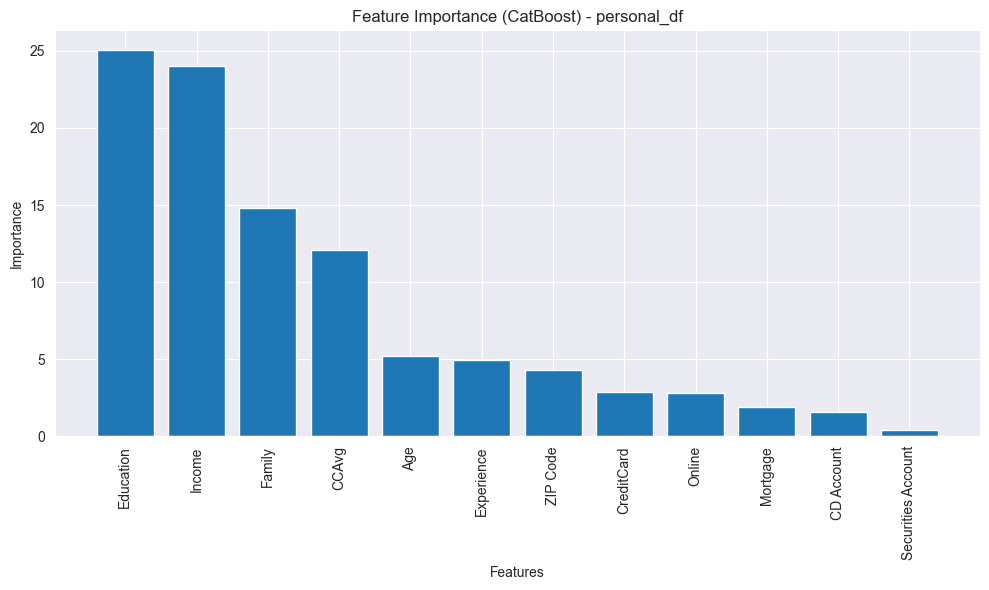

In [12]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances_p)), feature_importances_p[feature_indices_p])
plt.xticks(range(len(feature_importances_p)), [feature_names_p[i] for i in feature_indices_p], rotation=90)
plt.title("Feature Importance (CatBoost) - personal_df")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()